# Prediction of immunotherapy response
In this notebook, we train a binary classifier which predicts if a patient will have a response to immunotherapy treatment or not.

## Plan :
1. Reading the dataset
2. Training the model using leave one out cross validation
3. Evaluation of the model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models.BinaryClassifier import BinaryClassifier
from utils.preProcessing import preProcessing
from sklearn.linear_model import LogisticRegression

In [2]:
preprocessor = preProcessing()

## 1. Reading the dataset
We use the dataset from the following article : https://doi.org/10.1158/1078-0432.CCR-20-1163. We only keep naive patients.

In [3]:
df = pd.read_excel('data/Supplemental-table1.xlsx')
df = df.loc[df["Cohort"] == "Naive"]
df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,Alive_0,Time to progression (days),Progression_1,Clinical benefit,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Lymph related
0,14891,EGAD00001001961,LUNG,F,8,Nivolumab,Naive,Progression,Mixed,45,...,1,179,1,NCB,0.351869,11.095310,23.0729,4.1689,55.51575,Non-lymph related
1,18624,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,47,...,1,148,1,NCB,0.071464,3.876336,5.4552,0.7910,9.32352,Non-lymph related
2,21392,EGAD00001002544,OV,F,6,Monalizumab,Naive,Progression,Physician assessed SD,57,...,1,79,1,NCB,0.040394,2.415688,4.1274,4.0377,50.12008,Lymph related
3,21516,EGAD00001002546,SKCM,F,3,Ipilimumab,Naive,Death,Not evaluable,29,...,1,11,0,NCB,0.052774,6.235845,11.4871,0.6006,1.58550,Non-lymph related
4,22186,EGAD00001001966,LUNG,F,4,Atezolizumab,Naive,Progression,Stable disease,52,...,1,80,1,NCB,0.009323,4.606660,7.1503,1.8234,38.42695,Non-lymph related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,39280,EGAD00001004933,LUNG,M,2,Pembrolizumab,Naive,Toxicity,Physician Assessed SD,60,...,1,401,0,DCB,0.695396,84.998501,96.4079,8.4768,86.62561,Non-lymph related
94,37899,EGAD00001005838,CHOL,F,2,Nivolumab,Naive,Death,Physician assessed PR,38,...,1,96,0,NCB,0.818233,2.247151,2.7416,11.2704,47.97376,Non-lymph related
95,37775,EGAD00001004934,HNSC,M,1,Avelumab/OX40 agonist PF-04518600,Naive,Progression,Stable disease,69,...,1,69,1,NCB,0.018982,3.848247,5.8036,8.7136,5.13403,Non-lymph related
96,38313,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,34,...,1,51,1,NCB,0.000000,5.617878,7.7940,0.0688,0.51364,Non-lymph related


## 2. Training process with cross validation
Here, we select the logistic regression model. We train it using the leave one out cross validation (which is the KFold cross validation with K = n_samples), so at the end of the process, each patient has a test score and a test class. The features we use are :
- Age
- CD8+ T cell score
- Genome mut per mb
- Exome mut per mb
- CD274 expression
- M1M2 expression

The label column is the ```Clinical benefit``` column, and we numerize it.

In [4]:
# Select features matrix and label vector
X = df.loc[:,["Age at advanced disease diagnosis","CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression"]].to_numpy()
y = np.where(df["Clinical benefit"].to_numpy() == "DCB",1,0)

# Normalize the dataset
X = preprocessor.normalize_data(X)

# Instanciate the classifier
clf = BinaryClassifier(LogisticRegression())

# Make the leave one out CV
y_pred, y_score = clf.leave_one_out_cross_validation(X, y)

## 3. Evaluate the model
We compute the accuracy, precision, recall and F1-score. We also plot the ROC curve with the AUC value.

In [5]:
# Accuracy, precision, recall, F1
acc, pre, rec, f1 = clf.eval_metrics_from_conf_matrix(y, y_pred)
print(f"Accuracy : {acc}")
print(f"Precision : {pre}")
print(f"Recall : {rec}")
print(f"F1-score : {f1}")

Accuracy : 0.8
Precision : 0.57
Recall : 0.24
F1-score : 0.33


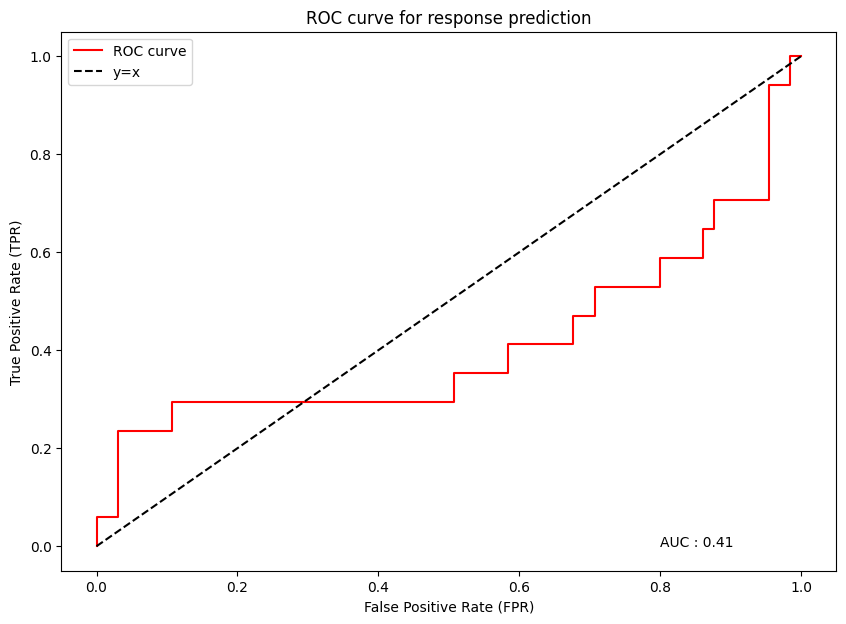

In [6]:
# ROC curve and AUC
fpr, tpr, thresholds = clf.compute_roc_curve(y, y_score)
auc = clf.compute_auc(y, y_score)

fig, ax = plt.subplots(figsize=(10,7))
x = np.linspace(0,1,100)
ax.plot(fpr, tpr, color='red',label='ROC curve')
ax.plot(x,x,linestyle='--',color='black',label='y=x')
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
ax.set_title('ROC curve for response prediction')
ax.text(0.8,0,f"AUC : {auc}")

plt.legend()
plt.savefig("ROC-curve.png")